<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week8_ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Classification

### Dataset: [Breast Cancer Wisconsin (Diagnostic)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

- **Samples**: 569
- **Features**: 30 (radius, texture, perimeter, area, smoothness, etc.)
- **Classes**: 2 (malignant, benign)
- **Task**: Binary classification

In [20]:
# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.datasets import load_breast_cancer

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.3
CV_FOLDS = 5
OPTUNA_N_TRIALS = 10

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)

cancer = load_breast_cancer()
print(f"Data shape: {cancer.data.shape}")
print(f"Target shape: {cancer.target.shape}")
print(f"Feature names: {cancer.feature_names}... (30 total)")
print(f"Target names: {cancer.target_names}")
print(f"Class distribution: {dict(zip(*np.unique(cancer.target, return_counts=True)))}")

Data shape: (569, 30)
Target shape: (569,)
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']... (30 total)
Target names: ['malignant' 'benign']
Class distribution: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

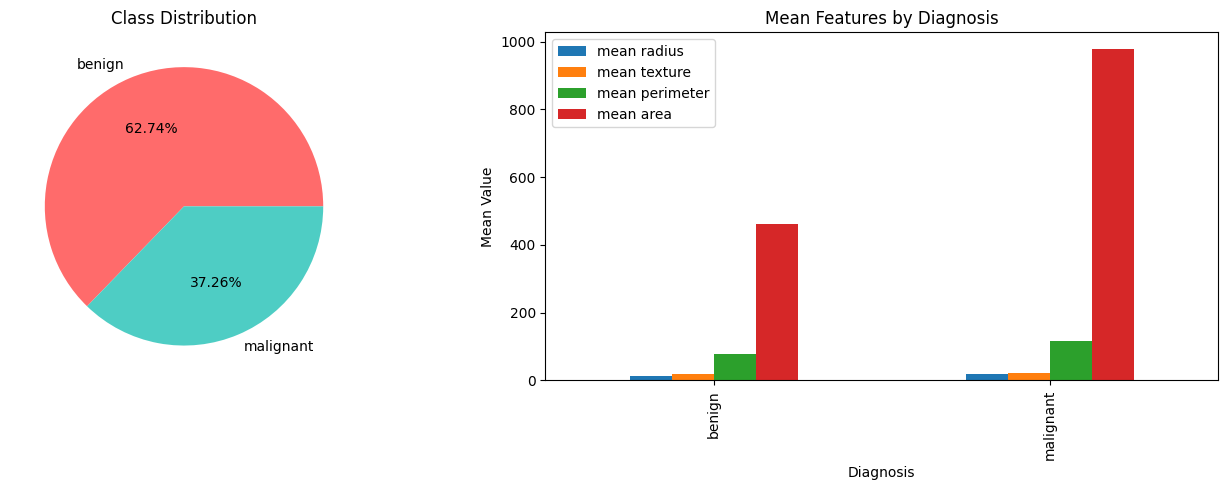

In [22]:
# Create DataFrame for EDA
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df['diagnosis'] = cancer_df['target'].map({0: 'malignant', 1: 'benign'})

# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class balance
axes[0].pie(cancer_df['diagnosis'].value_counts(),
            labels=cancer_df['diagnosis'].value_counts().index,
            autopct='%1.2f%%', colors=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Class Distribution')

# Feature statistics by class
features = cancer_df.columns.drop(['target', 'diagnosis'])
cancer_df.groupby('diagnosis')[features[0:4]].mean().plot(
    kind='bar', ax=axes[1] )#, color=['#ff6b6b', '#4ecdc4', '#336699'])
axes[1].set_title('Mean Features by Diagnosis')
axes[1].set_xlabel('Diagnosis')
axes[1].set_ylabel('Mean Value')
axes[1].legend(loc='best')
plt.tight_layout()
plt.show()

## 2. Exploratory Data Analysis (EDA)

In [23]:
print("Dataset Statistics:")
print(cancer_df.info())

print("\nMissing Values:")
print(cancer_df.isnull().sum().sum())

Dataset Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smooth

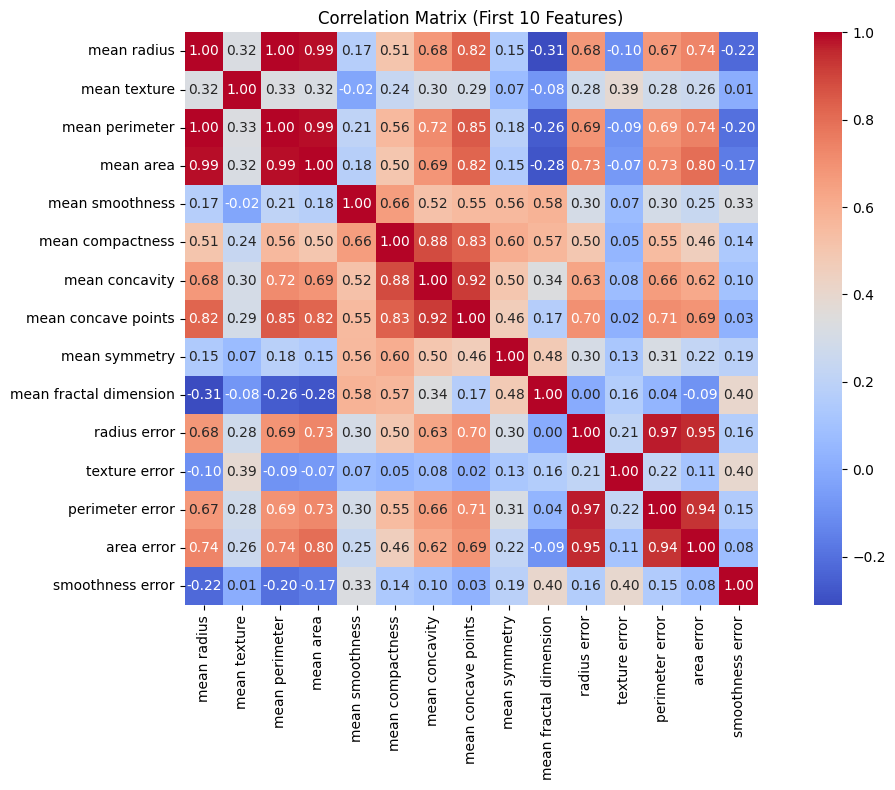


Correlations with Target (Top 10):
worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
Name: target, dtype: float64


In [24]:
import seaborn as sns

# Create correlation matrix with target included
corr_data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
corr_data['target'] = cancer.target
corr_matrix = corr_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.iloc[:15, :15], annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (First 10 Features)")
plt.tight_layout()
plt.show()

print("\nCorrelations with Target (Top 10):")
corr_with_target = corr_matrix['target'].drop('target').abs().sort_values(ascending=False)[:10]
print(corr_with_target)

## 3. Feature Selection

### 3.1 Correlation-Based Feature Selection

In [25]:
# Use corr_data from previous cell or recreate it
'''if 'corr_data' not in locals():
    corr_data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
    corr_data['target'] = cancer.target
    corr_matrix = corr_data.corr()
else:
    corr_matrix = corr_data.corr()'''

correlations = corr_matrix['target'].drop('target').abs().sort_values(ascending=False)

#print("Feature Correlations with Target (Absolute Values):")
#print(correlations)

corr_threshold = 0.6
selected_features_corr = correlations[correlations > corr_threshold].index.tolist()

print(f"\nSelected features (correlation > {corr_threshold}): {len(selected_features_corr)}")
print(selected_features_corr)


Selected features (correlation > 0.6): 10
['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter', 'worst area', 'mean radius', 'mean area', 'mean concavity', 'worst concavity']


### 3.2 SelectKBest with f_classif

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

k_features = 10
selector_kbest = SelectKBest(score_func=f_classif, k=k_features)
X_kbest = selector_kbest.fit_transform(cancer.data, cancer.target)

selected_mask = selector_kbest.get_support()
selected_features_kbest = [f for f, selected in zip(cancer.feature_names, selected_mask) if selected]

print(f"Top {k_features} features selected by SelectKBest (f_classif):")
print(selected_features_kbest)

print("\nF-scores for all features (top 10):")
for feature, score in sorted(zip(cancer.feature_names, selector_kbest.scores_),
                              key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {feature}: {score:.4f}")

Top 10 features selected by SelectKBest (f_classif):
[np.str_('mean radius'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('worst radius'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst concavity'), np.str_('worst concave points')]

F-scores for all features (top 10):
  worst concave points: 964.3854
  worst perimeter: 897.9442
  mean concave points: 861.6760
  worst radius: 860.7817
  mean perimeter: 697.2353
  worst area: 661.6002
  mean radius: 646.9810
  mean area: 573.0607
  mean concavity: 533.7931
  worst concavity: 436.6919


### 3.3 SelectFromModel with L1-based Classifier

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr_fs = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)
lr_fs.fit(cancer.data, cancer.target)

selector_lr = SelectFromModel(lr_fs, prefit=True)
X_lr_selected = selector_lr.transform(cancer.data)

selected_mask_lr = selector_lr.get_support()
selected_features_lr = [f for f, selected in zip(cancer.feature_names, selected_mask_lr) if selected]

print("Features selected by Logistic Regression L1 (non-zero coefficients):")
print(selected_features_lr)
print(f"\nNumber of features selected: {len(selected_features_lr)}")

Features selected by Logistic Regression L1 (non-zero coefficients):
[np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('texture error'), np.str_('area error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst concavity')]

Number of features selected: 11


### 3.4 Feature Selection Summary

In [28]:
fs_comparison = pd.DataFrame({'Feature': list(cancer.feature_names)})
fs_comparison['Correlation'] = fs_comparison['Feature'].isin(selected_features_corr)
fs_comparison['SelectKBest'] = fs_comparison['Feature'].isin(selected_features_kbest)
fs_comparison['L1_Logistic'] = fs_comparison['Feature'].isin(selected_features_lr)

fs_comparison.set_index('Feature', inplace=True)
print("Feature Selection Comparison:")
print(fs_comparison)

print("\nNumber of features selected by each method:")
print(f"  Correlation-based: {len(selected_features_corr)}")
print(f"  SelectKBest (k={k_features}): {len(selected_features_kbest)}")
print(f"  L1 Logistic: {len(selected_features_lr)}")

best_features = fs_comparison[fs_comparison.sum(axis=1) >= 2] #Majority vote
print(best_features)

Feature Selection Comparison:
                         Correlation  SelectKBest  L1_Logistic
Feature                                                       
mean radius                     True         True         True
mean texture                   False        False         True
mean perimeter                  True         True         True
mean area                       True         True         True
mean smoothness                False        False        False
mean compactness               False        False        False
mean concavity                  True         True        False
mean concave points             True         True        False
mean symmetry                  False        False        False
mean fractal dimension         False        False        False
radius error                   False        False        False
texture error                  False        False         True
perimeter error                False        False        False
area error               

## 4. Data Preprocessing & Train-Test Split

### Holdout technique

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#best_indices = [feature_names_list.index(f) for f in best_features]
X_best = cancer_df[best_features.index.to_list()]

X_train, X_test, y_train, y_test = train_test_split(
    X_best, cancer.target,
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=cancer.target
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"\nClass distribution in y_train: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Class distribution in y_test: {dict(zip(*np.unique(y_test, return_counts=True)))}")


Shape of X_train: (398, 10)
Shape of X_test: (171, 10)
Shape of y_train: (398,)
Shape of y_test: (171,)

Class distribution in y_train: {np.int64(0): np.int64(148), np.int64(1): np.int64(250)}
Class distribution in y_test: {np.int64(0): np.int64(64), np.int64(1): np.int64(107)}


## 5. Pipeline and Hyperparameter Tuning

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score, accuracy_score, f1_score

## 1. GridSearchCV method

In [31]:
# Define pipelines for both classifiers
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=2000))
    ]),
    'GaussianNB': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GaussianNB())
    ])
}

# Parameter grids for each classifier
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    'GaussianNB': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    }
}

results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print('='*60)

    grid_search = GridSearchCV(pipeline, param_grids[name], scoring='matthews_corrcoef',
                               cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE), n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters found by GridSearchCV for {name}:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    results[name] = {'accuracy': acc, 'f1': f1, 'mcc': mcc}

#print(results)
    #print(f"\nTest Accuracy: {acc:.4f}")
    #print(f"Test F1 Score: {f1:.4f}")

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: Model Comparison")
print("="*60)
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['accuracy']:.4f}, F1 = {metrics['f1']:.4f}, MCC = {metrics['mcc']:.4f}")


Training LogisticRegression
Best parameters found by GridSearchCV for LogisticRegression:
{'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Training GaussianNB
Best parameters found by GridSearchCV for GaussianNB:
{'classifier__var_smoothing': 1e-09}

SUMMARY: Model Comparison
LogisticRegression: Accuracy = 0.9591, F1 = 0.9680, MCC = 0.9130
GaussianNB: Accuracy = 0.9298, F1 = 0.9439, MCC = 0.8502


## 2. RandomizedSearchCV

In [32]:
from scipy.stats import loguniform
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

# Use the pipeline defined above

# Parameter distributions for each classifier
param_distributions = {
    'LogisticRegression': {
        'classifier__C': loguniform(0.01, 100),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },
    'GaussianNB': {
        'classifier__var_smoothing': loguniform(1e-9, 1e-5)
    }
}

results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f"Training {name} with RandomizedSearchCV")
    print('='*60)

    random_search = RandomizedSearchCV(pipeline, param_distributions[name], n_iter=100,
                                       scoring='matthews_corrcoef', cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
                                       n_jobs=-1, random_state=RANDOM_STATE)
    random_search.fit(X_train, y_train)

    print(f"Best parameters found by RandomizedSearchCV for {name}:")
    print(random_search.best_params_)

    best_random_model = random_search.best_estimator_
    y_pred_random = best_random_model.predict(X_test)

    acc_random = accuracy_score(y_test, y_pred_random)
    f1_random = f1_score(y_test, y_pred_random)
    mcc_random = matthews_corrcoef(y_test, y_pred_random)

    results[name] = {'accuracy': acc_random, 'f1': f1_random, 'mcc': mcc_random}

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: Model Comparison (RandomizedSearchCV)")
print("="*60)
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['accuracy']:.4f}, F1 = {metrics['f1']:.4f}, MCC = {metrics['mcc']:.4f}")


Training LogisticRegression with RandomizedSearchCV
Best parameters found by RandomizedSearchCV for LogisticRegression:
{'classifier__C': np.float64(7.707580772445939), 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Training GaussianNB with RandomizedSearchCV
Best parameters found by RandomizedSearchCV for GaussianNB:
{'classifier__var_smoothing': np.float64(3.148911647956859e-08)}

SUMMARY: Model Comparison (RandomizedSearchCV)
LogisticRegression: Accuracy = 0.9591, F1 = 0.9680, MCC = 0.9130
GaussianNB: Accuracy = 0.9298, F1 = 0.9439, MCC = 0.8502


### Optuna

In [33]:
!pip install optuna -qqq

In [34]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, matthews_corrcoef, average_precision_score

# Define stratified CV for reproducibility
cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier",
        ["LogisticRegression", "GaussianNB"])
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if classifier_name == "LogisticRegression":
      C = trial.suggest_float("lr_C", 0.01, 100, log=True)
      penalty = trial.suggest_categorical("lr_penalty", ["l1", "l2"])
      solver = trial.suggest_categorical("lr_solver", ['liblinear', 'saga'])
      pipe.set_params(classifier=LogisticRegression(
          C=C,
          penalty=penalty,
          solver=solver,
          random_state=RANDOM_STATE,
          max_iter=1000,
          class_weight='balanced'))  #Handle imbalanced data

    elif classifier_name == "GaussianNB":
      var_smoothing = trial.suggest_float("nb_var_smoothing", 1e-9, 1e-5, log=True)
      pipe.set_params(classifier=GaussianNB(var_smoothing=var_smoothing))

    score = cross_val_score(pipe, X_train, y_train, cv=cv_splitter,  #Stratified CV
                          scoring='matthews_corrcoef', n_jobs=-1)

    return score.mean()

In [35]:
#Set seed properly with TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))

study.optimize(objective, n_trials=OPTUNA_N_TRIALS)

if study.best_trial is not None:

    print("Best parameters found by Optuna:")
    print(study.best_params)

    print(f"Best value: {study.best_value:.4f}")

    best_params = study.best_params
    best_classifier_name = best_params["classifier"]

    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if best_classifier_name == "LogisticRegression":
        best_C = best_params["lr_C"]
        best_penalty = best_params["lr_penalty"]
        best_solver = best_params["lr_solver"]
        best_pipeline.set_params(classifier=LogisticRegression(
            C=best_C, penalty=best_penalty, solver=best_solver,
            random_state=RANDOM_STATE, max_iter=1000,
            class_weight='balanced'))
    elif best_classifier_name == "GaussianNB":
        best_var_smoothing = best_params["nb_var_smoothing"]
        best_pipeline.set_params(classifier=GaussianNB(
            var_smoothing=best_var_smoothing))

    best_pipeline.fit(X_train, y_train)
    y_pred_optuna = best_pipeline.predict(X_test)

    roc_auc_optuna = roc_auc_score(y_test, y_pred_optuna)
    mcc_optuna = matthews_corrcoef(y_test, y_pred_optuna)
    f1_optuna = f1_score(y_test, y_pred_optuna)

    print(f"\nTest ROC-AUC: {roc_auc_optuna:.4f}")
    print(f"Test MCC: {mcc_optuna:.4f}")
    print(f"Test F1: {f1_optuna:.4f}")
else:
    print("Optuna did not complete any trials successfully.")

print("\n--- Optuna Study Results ---")
print(f"Number of completed trials: {len(study.trials)}")
print(f"Best value: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

print("\n--- All Trials ---")
df = study.trials_dataframe()
print(df[["value", "params_classifier"]].to_string())

[I 2026-02-27 07:17:21,524] A new study created in memory with name: no-name-607a6ae8-e8bb-4513-b4de-638ef61059c2
[I 2026-02-27 07:17:21,586] Trial 0 finished with value: 0.8888471336687627 and parameters: {'classifier': 'GaussianNB', 'nb_var_smoothing': 8.471801418819974e-07}. Best is trial 0 with value: 0.8888471336687627.
[I 2026-02-27 07:17:21,661] Trial 1 finished with value: 0.8842621654167792 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.042070539502879395, 'lr_penalty': 'l2', 'lr_solver': 'saga'}. Best is trial 0 with value: 0.8888471336687627.
[I 2026-02-27 07:17:21,711] Trial 2 finished with value: 0.8888471336687627 and parameters: {'classifier': 'GaussianNB', 'nb_var_smoothing': 2.1368329072358738e-06}. Best is trial 0 with value: 0.8888471336687627.
[I 2026-02-27 07:17:21,783] Trial 3 finished with value: 0.874014476184302 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.05415244119402541, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}. Best i

Best parameters found by Optuna:
{'classifier': 'LogisticRegression', 'lr_C': 4.467752817973908, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}
Best value: 0.9120

Test ROC-AUC: 0.9251
Test MCC: 0.8502
Test F1: 0.9439

--- Optuna Study Results ---
Number of completed trials: 10
Best value: 0.9120
Best params: {'classifier': 'LogisticRegression', 'lr_C': 4.467752817973908, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}

--- All Trials ---
      value   params_classifier
0  0.888847          GaussianNB
1  0.884262  LogisticRegression
2  0.888847          GaussianNB
3  0.874014  LogisticRegression
4  0.884842  LogisticRegression
5  0.888847          GaussianNB
6  0.873628  LogisticRegression
7  0.888847          GaussianNB
8  0.888847          GaussianNB
9  0.911975  LogisticRegression


In Optuna, the objective value is the performance metric returned by the objective function for a given set of hyperparameters in a single trial. This value is what Optuna aims to either maximize (e.g., accuracy, F1-score) or minimize (e.g., loss, mean squared error) during the optimization process.

In [36]:
try:
    from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice
    fig1 = plot_optimization_history(study)
    fig1.show()
except ImportError:
    print("Install optuna visualization with: pip install optuna-integration")

## 6. SHAP Analysis - Model Interpretability

In [37]:
!pip install shap -qqq

  0%|          | 0/100 [00:00<?, ?it/s]

X_test shape: (100, 10)
SHAP values shape: (100, 10)
Number of features: 30

SHAP Summary Plot:


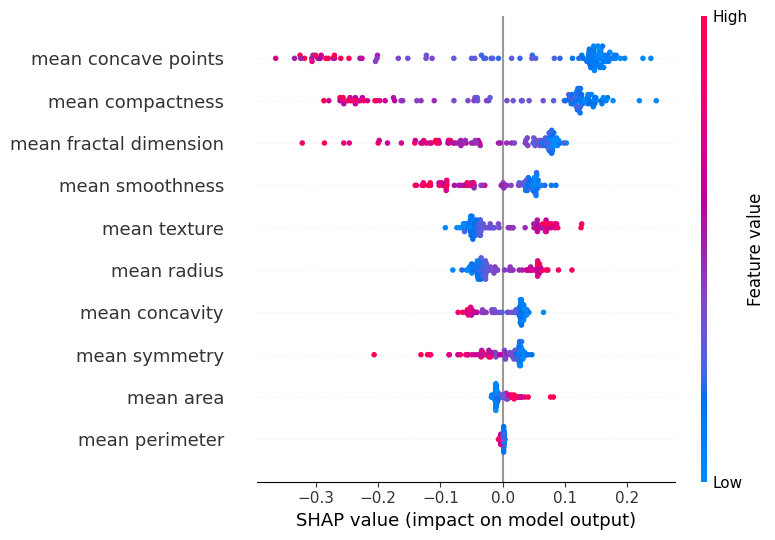


SHAP Feature Importance (Bar Plot):


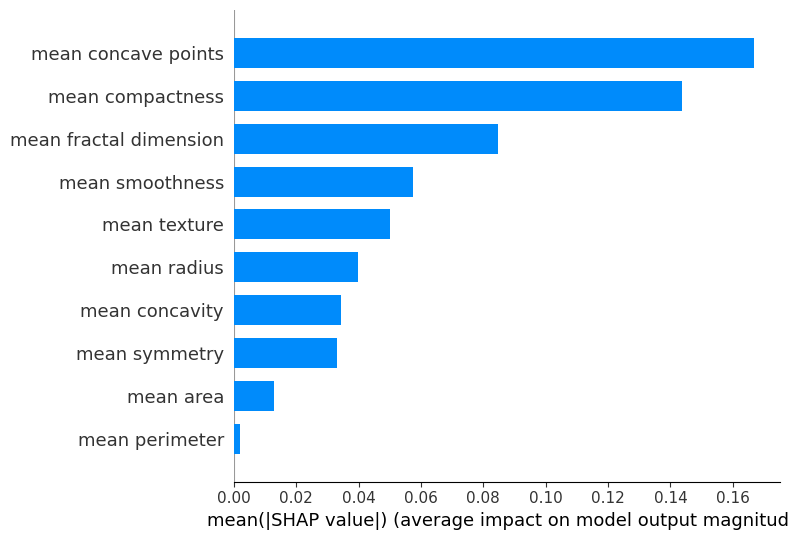


SHAP Dependence Plot for Most Important Feature:


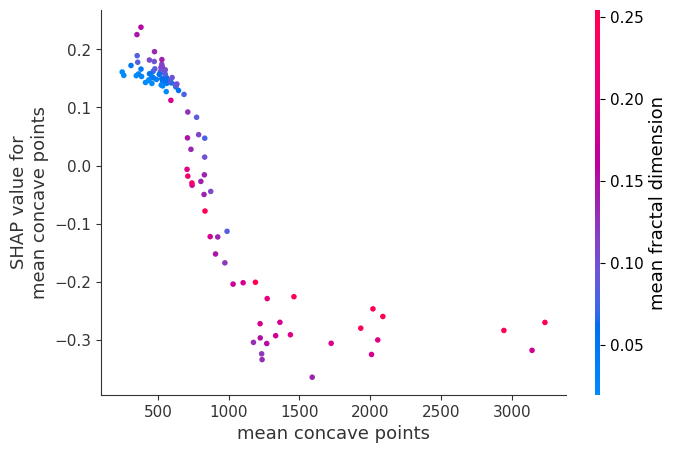

In [38]:
import shap

if study.best_trial is not None:
    best_params = study.best_params
    best_classifier_name = best_params["classifier"]

    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', None)
    ])

    if best_classifier_name == "LogisticRegression":
        best_C = best_params["lr_C"]
        best_penalty = best_params["lr_penalty"]
        best_pipeline.set_params(classifier=LogisticRegression(
            C=best_C, penalty=best_penalty, solver='liblinear',
            random_state=RANDOM_STATE, max_iter=1000))
    elif best_classifier_name == "GaussianNB":
        best_var_smoothing = best_params["nb_var_smoothing"]
        best_pipeline.set_params(classifier=GaussianNB(
            var_smoothing=best_var_smoothing))

    best_pipeline.fit(X_train, y_train)

    # For SHAP, we need to use the model's predict_proba
    # Create a wrapper function
    def model_predict(X):
        return best_pipeline.predict_proba(X)[:, 1]  # Probability of positive class

    # Use KernelExplainer which works with any function
    explainer = shap.KernelExplainer(model_predict, X_train)

    # Compute SHAP values (use a subset for speed)
    np.random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    X_sample = X_train.iloc[np.random.choice(len(X_train), 100, replace=False)]
    shap_values = explainer.shap_values(X_sample)

    # Print shape information for debugging
    print(f"X_test shape: {X_sample.shape}")
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Number of features: {len(cancer.feature_names)}")

    # SHAP Summary Plot
    print("\nSHAP Summary Plot:")
    shap.summary_plot(shap_values, X_sample, feature_names=cancer.feature_names, show=False)
    plt.show()

    # SHAP Bar Plot
    print("\nSHAP Feature Importance (Bar Plot):")
    shap.summary_plot(shap_values, X_sample, feature_names=cancer.feature_names,
                      plot_type="bar", show=False)
    plt.show()

    # SHAP Dependence Plot
    print("\nSHAP Dependence Plot for Most Important Feature:")
    shap_values_arr = np.array(shap_values)
    most_important_idx = np.argmax(np.abs(shap_values_arr).mean(axis=0))
    shap.dependence_plot(most_important_idx, shap_values_arr, X_sample,
                        feature_names=cancer.feature_names, show=False)
    plt.show()
else:
    print("No trained model available for SHAP analysis. Run the Optuna optimization first.")

### Key Insights from SHAP Analysis:
1. **Feature Importance**: Features at the top have the greatest impact on predictions.
2. **Positive/Negative Impact**: Red = high values increase prediction, blue = decrease.
3. **For Classification**: SHAP shows impact on probability of each class.

### Hint
1. You should choose RandomizedSearch over GridSearch for many hyperparameters.
2. For imbalanced datasets, use stratified CV and appropriate metrics (F1, ROC-AUC).
3. SHAP values help explain which features drive classification decisions.

#Exercise: Loan classification

#### Given the dataset below, apply the technique you learned above to create classification models, and then explain the features that impact the ML results

https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/refs/heads/master/Week08-workshop-2/loan_data.csv
